<a href="https://colab.research.google.com/github/andrewolf80550/AA/blob/main/ReingresoHospitalario2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Ya subiste el archivo, ahora lo cargas en un DataFrame
archivo = '/content/Base_de_datos_reingreso2.csv'  # Ruta en Colab
df = pd.read_csv(archivo)

# Eliminar la columna 'Distancia_Al_Hospital'
df = df.drop(columns='Distancia_Al_Hospital')

# Identificar la variable objetivo y las características
X = df.drop(columns='Reingreso')
y = df['Reingreso']

# Separar las características en numéricas y categóricas
columnas_numericas = X.select_dtypes(include=[np.number]).columns.tolist()
columnas_categoricas = X.select_dtypes(include=[object]).columns.tolist()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el preprocesador y el modelo
preprocesador = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
        ('cat', OneHotEncoder(), columnas_categoricas)
    ]
)

# Pipeline para regresión logística
pipeline_logistic = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('modelo', LogisticRegression(max_iter=1000, random_state=42))
])
pipeline_logistic.fit(X_train, y_train)

# Pipeline para RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
pipeline_rf = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('modelo', rf_model)
])
pipeline_rf.fit(X_train, y_train)

# Pipeline para Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
pipeline_gb = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('modelo', gb_model)
])
pipeline_gb.fit(X_train, y_train)

# Obtener nombres de características
preprocesador_ajustado = pipeline_logistic.named_steps['preprocesador']
onehot_encoder = preprocesador_ajustado.named_transformers_['cat']
onehot_encoder.fit(X_train[columnas_categoricas])  # Ajustar el OneHotEncoder
nombres_columnas = onehot_encoder.get_feature_names_out(columnas_categoricas)

nombres_columnas_numericas = columnas_numericas
nombres_columnas_rf = np.concatenate([nombres_columnas_numericas, nombres_columnas])

# Obtener coeficientes de regresión logística
coeficientes = pipeline_logistic.named_steps['modelo'].coef_[0]
df_coeficientes = pd.DataFrame({
    'Característica': nombres_columnas_rf,
    'Coeficiente_Logistico': coeficientes
})

# Calcular los valores absolutos de los coeficientes
df_coeficientes['Abs_Coeficiente_Logistico'] = df_coeficientes['Coeficiente_Logistico'].abs()

# Obtener importancias de características de RandomForest
importancias_rf = pipeline_rf.named_steps['modelo'].feature_importances_
df_importancias_rf = pd.DataFrame({
    'Característica': nombres_columnas_rf,
    'Importancia_RF': importancias_rf
})

# Obtener importancias de características de Gradient Boosting
importancias_gb = pipeline_gb.named_steps['modelo'].feature_importances_
df_importancias_gb = pd.DataFrame({
    'Característica': nombres_columnas_rf,
    'Importancia_GB': importancias_gb
})

# Normalizar importancias y coeficientes
df_coeficientes['Coeficiente_Logistico_Normalizado'] = df_coeficientes['Abs_Coeficiente_Logistico'] / df_coeficientes['Abs_Coeficiente_Logistico'].max()
df_importancias_rf['Importancia_RF_Normalizada'] = df_importancias_rf['Importancia_RF'] / df_importancias_rf['Importancia_RF'].max()
df_importancias_gb['Importancia_GB_Normalizada'] = df_importancias_gb['Importancia_GB'] / df_importancias_gb['Importancia_GB'].max()

# Combinar las importancias
df_combined = pd.merge(df_coeficientes[['Característica', 'Coeficiente_Logistico_Normalizado']],
                       df_importancias_rf[['Característica', 'Importancia_RF_Normalizada']],
                       on='Característica', how='left')

df_combined = pd.merge(df_combined,
                       df_importancias_gb[['Característica', 'Importancia_GB_Normalizada']],
                       on='Característica', how='left')

df_combined['Importancia_Combinada'] = (df_combined['Coeficiente_Logistico_Normalizado'] +
                                        df_combined['Importancia_RF_Normalizada'].fillna(0) +
                                        df_combined['Importancia_GB_Normalizada'].fillna(0)) / 3

df_combined = df_combined.sort_values(by='Importancia_Combinada', ascending=False)

# Mostrar las variables más importantes combinadas
print("Variables más importantes combinadas:")
print(df_combined)

# Crear y guardar la gráfica combinada
plt.figure(figsize=(12, 8))
plt.bar(df_combined['Característica'], df_combined['Importancia_Combinada'], color='lightcoral')
plt.xlabel('Características')
plt.ylabel('Importancia Combinada')
plt.title('Importancia Combinada de las Variables en los Modelos de Regresión Logística, RandomForest y Gradient Boosting')
plt.xticks(rotation=90)  # Rotar etiquetas del eje x para mayor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir anotaciones
for index, value in enumerate(df_combined['Importancia_Combinada']):
    plt.text(index, value, f'{value:.2f}', va='bottom', ha='center', fontsize=10, color='black')

plt.tight_layout()
plt.savefig('/content/importancia_combinada.png')  # Guardar la gráfica combinada
plt.close()

# Mostrar la imagen guardada en Colab
from IPython.display import Image
Image('/content/importancia_combinada.png')


Primeras filas del DataFrame:
   Edad     Genero  Duracion_Hospitalizacion_Dias  \
0    69  Masculino                             29   
1    32   Femenino                             13   
2    89  Masculino                             24   
3    78   Femenino                              3   
4    38  Masculino                             15   

   Numero_Visitas_Urgencias_Ultimo_Año  Numero_Diagnosticos  \
0                                    9                    1   
1                                    3                    4   
2                                    3                    4   
3                                    2                    1   
4                                    3                    2   

  Condiciones_Cronicas Tipo_Seguimiento_Post_Hospitalizacion  \
0              Ninguna                                  Alto   
1           Tres o más                               Ninguno   
2           Tres o más                                  Bajo   
3               

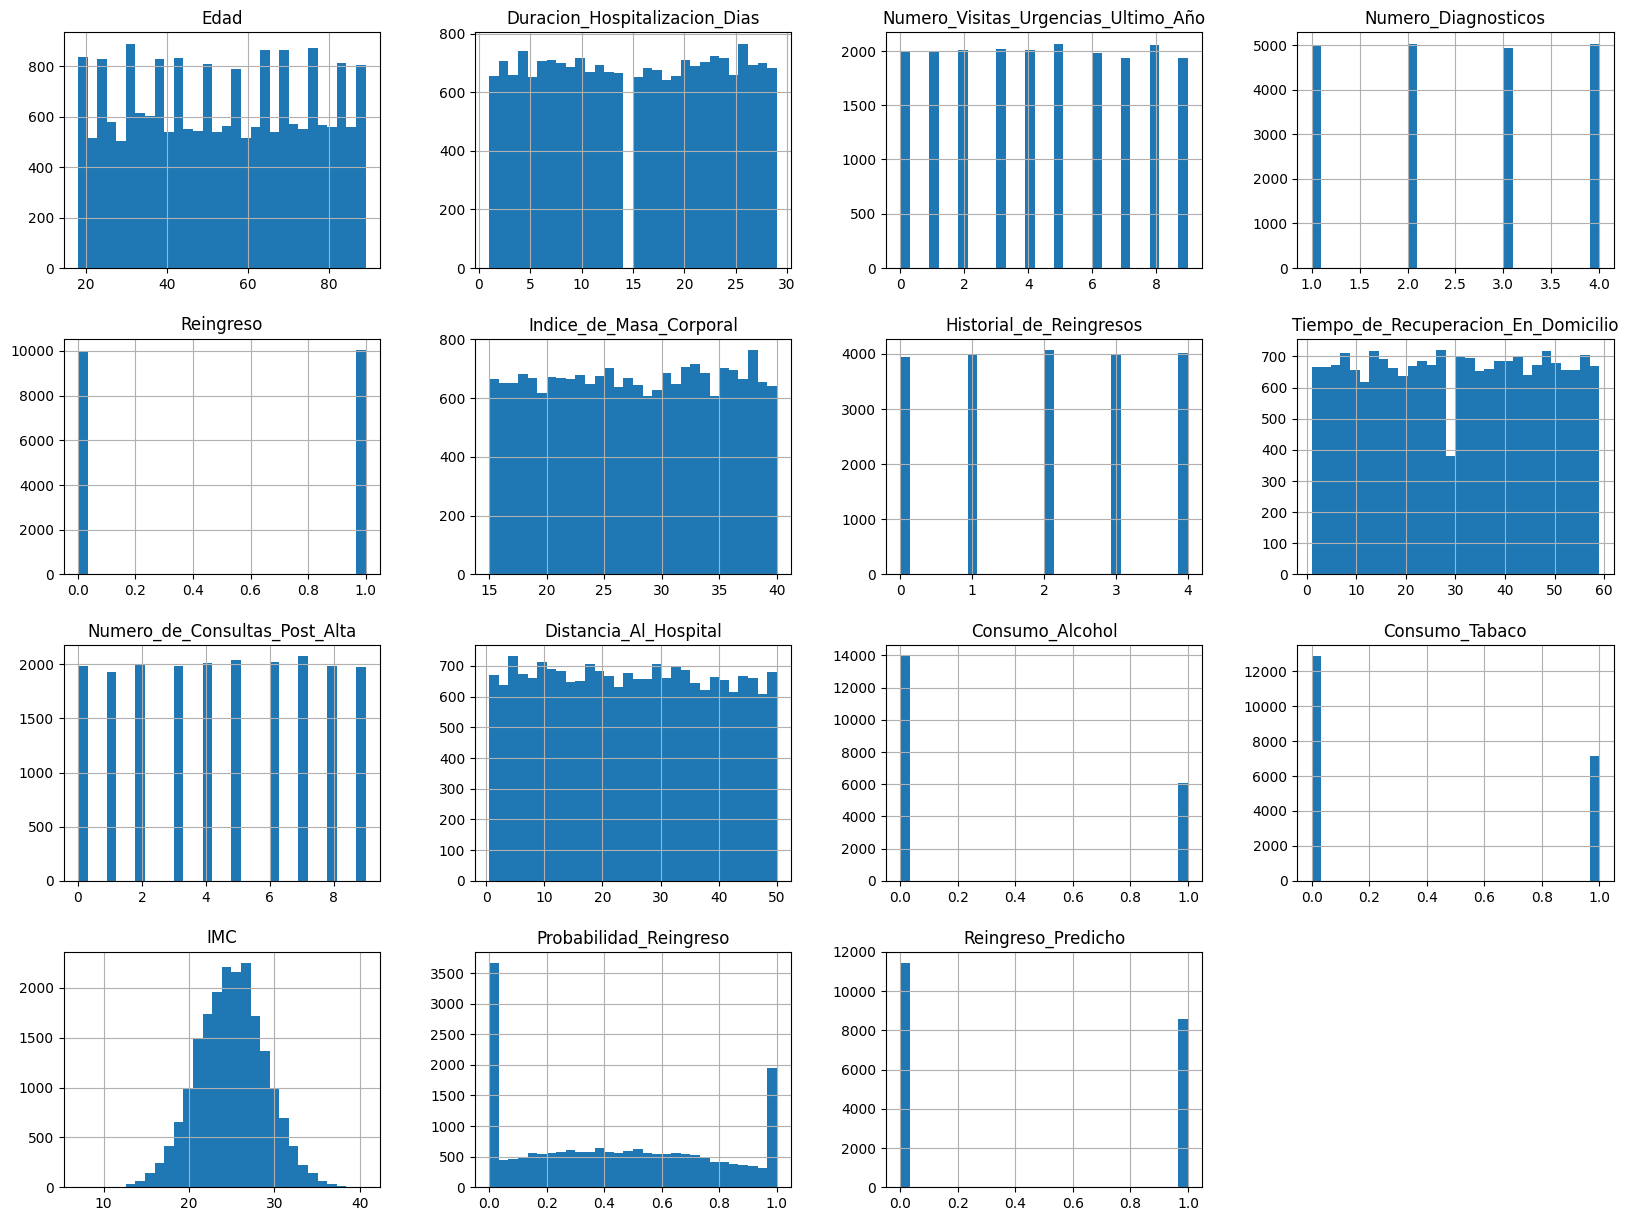

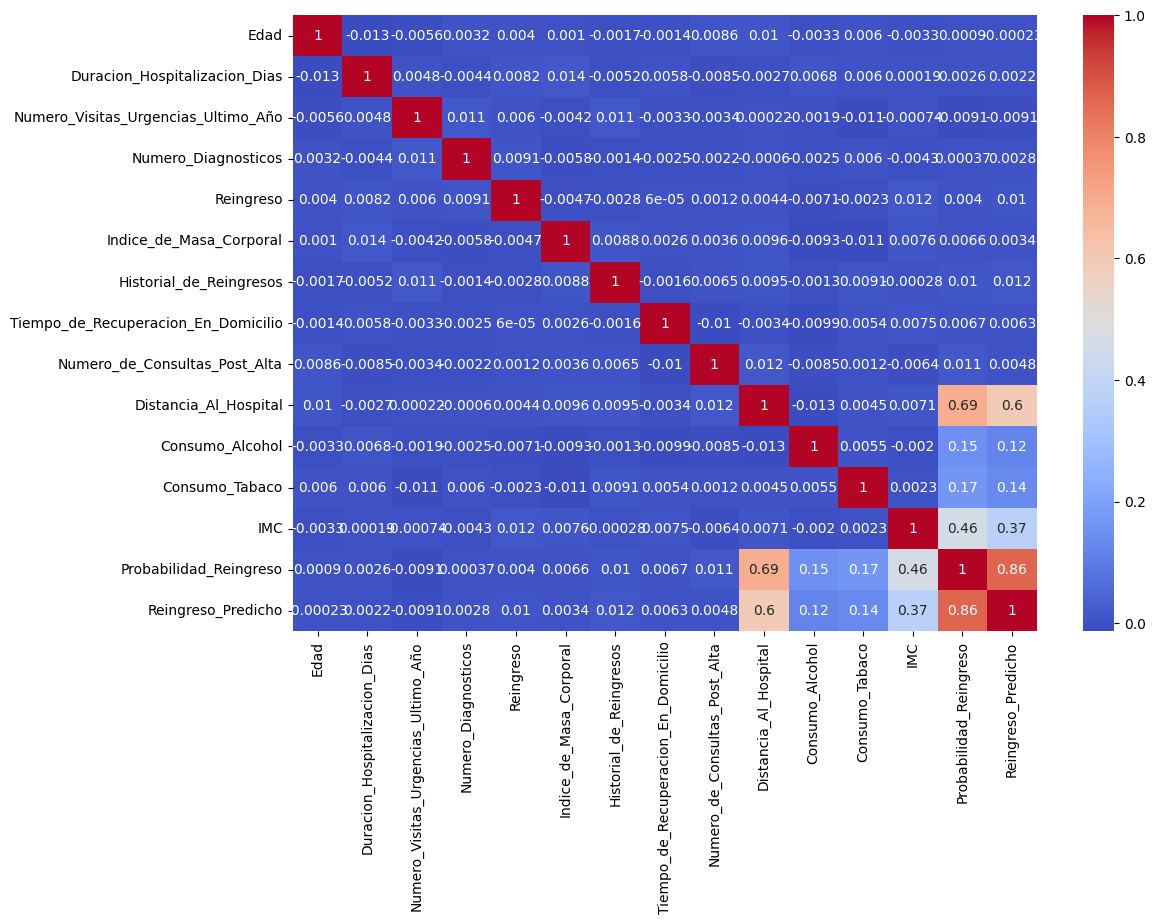

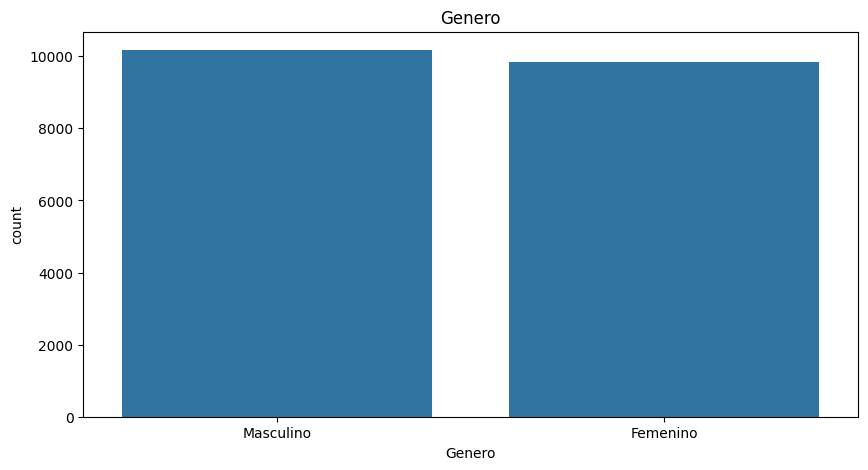

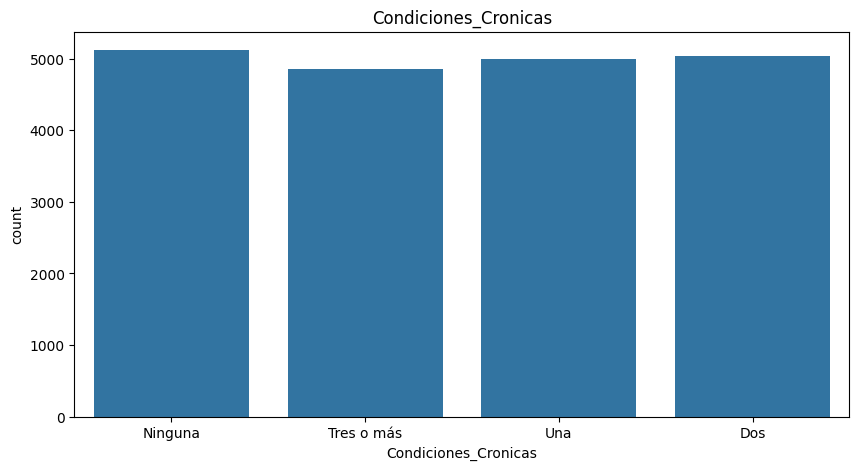

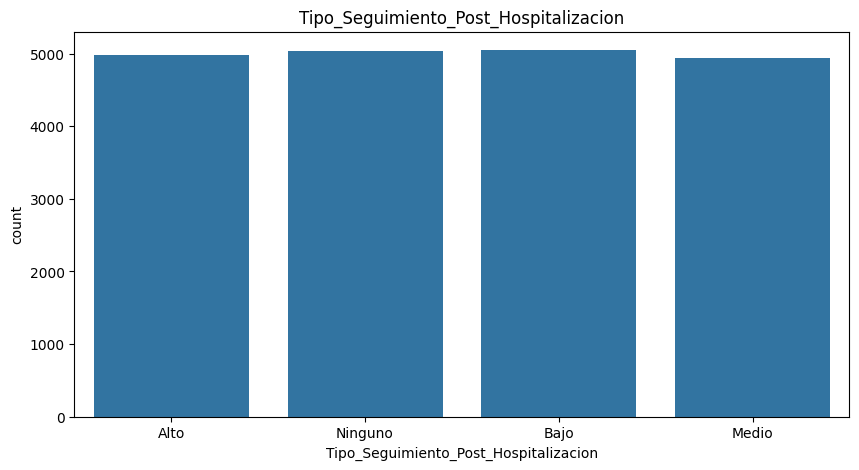

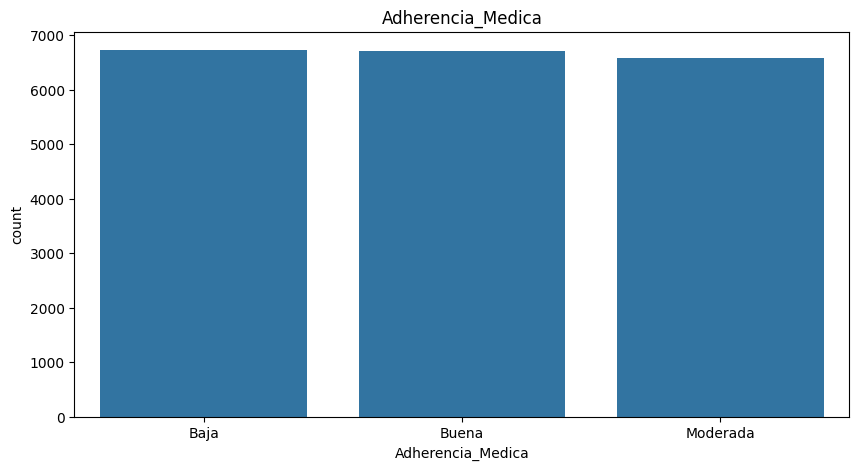

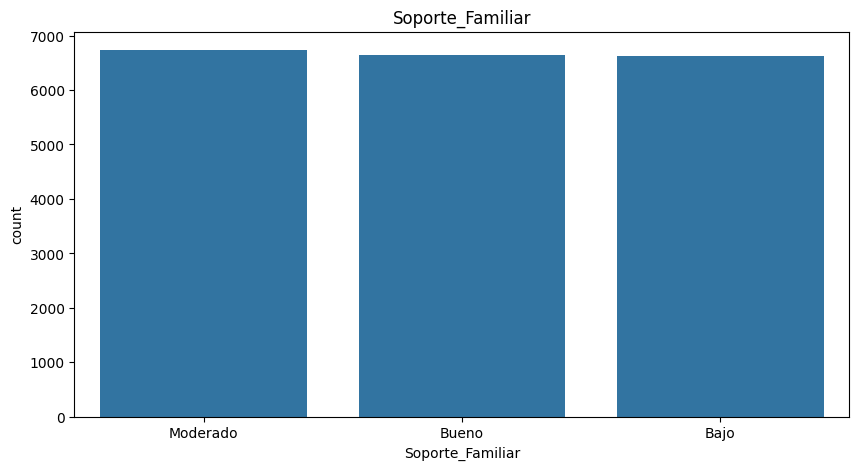

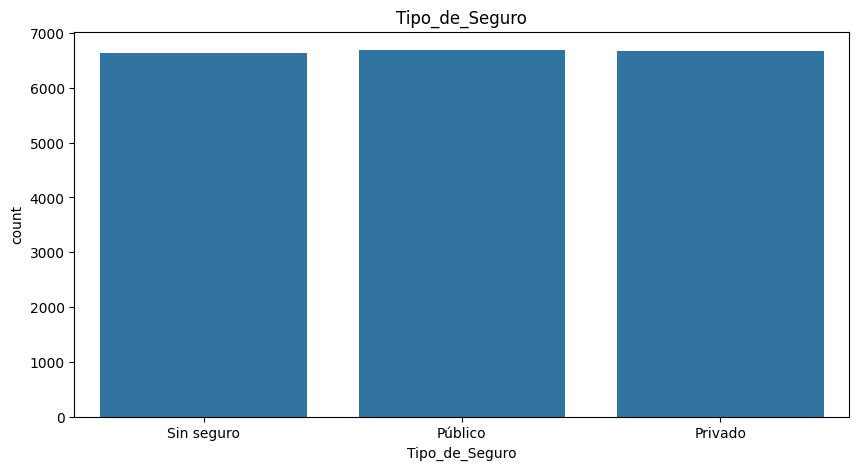

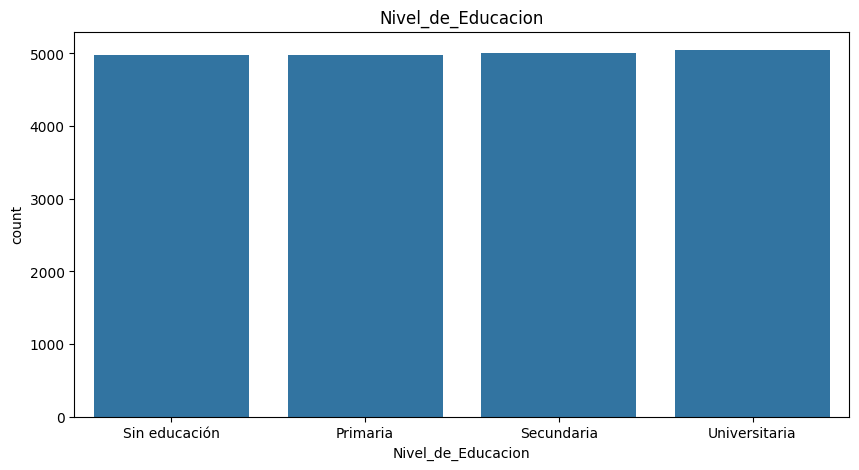

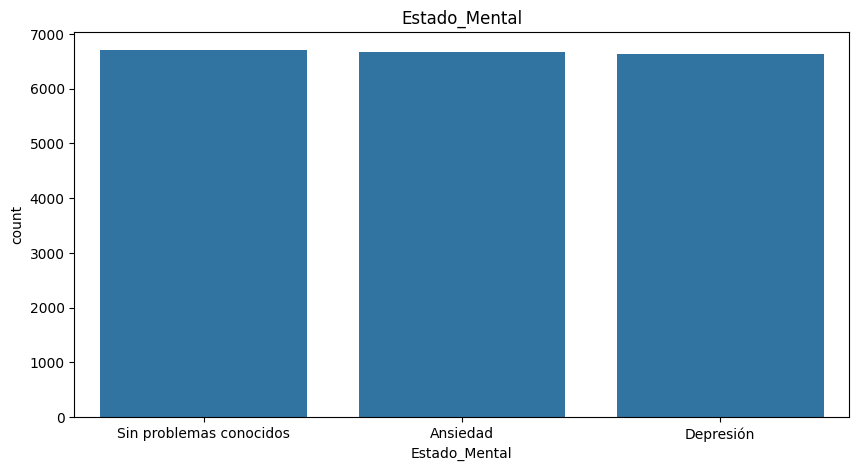

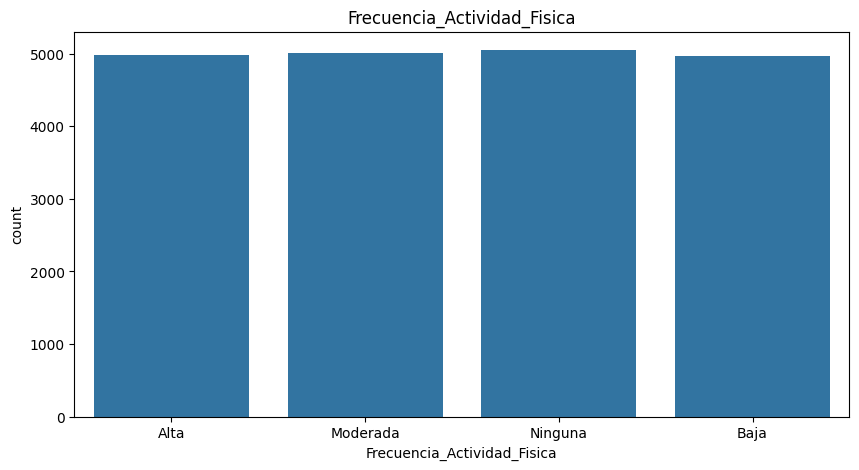

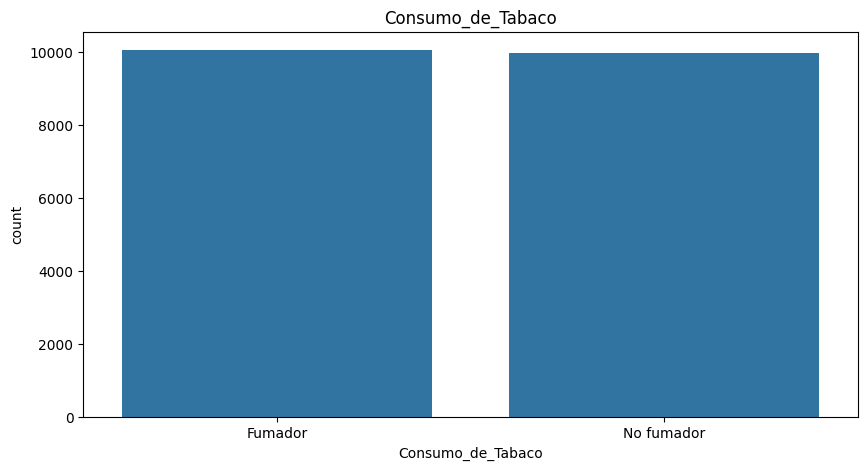

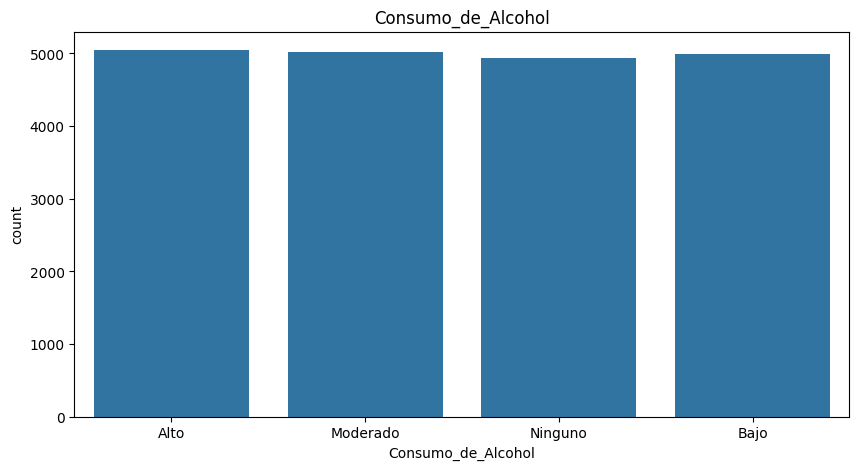

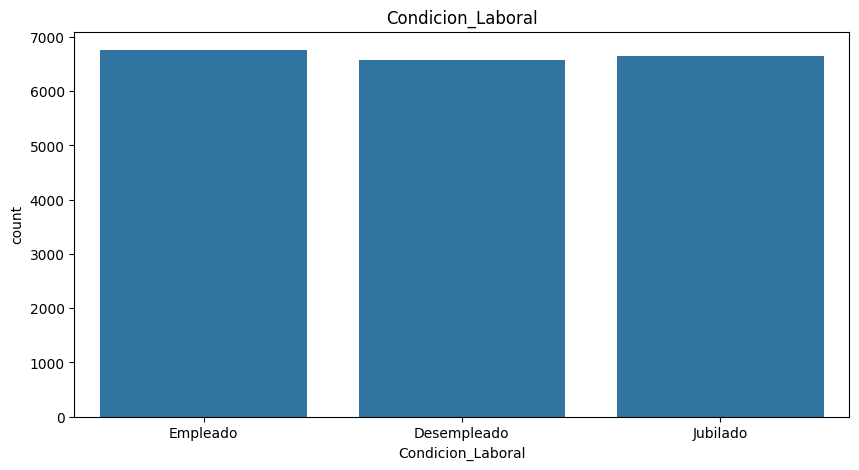

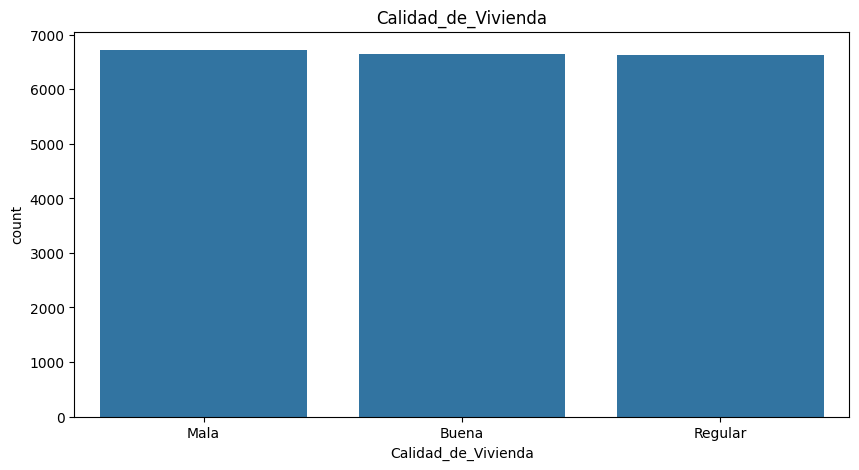

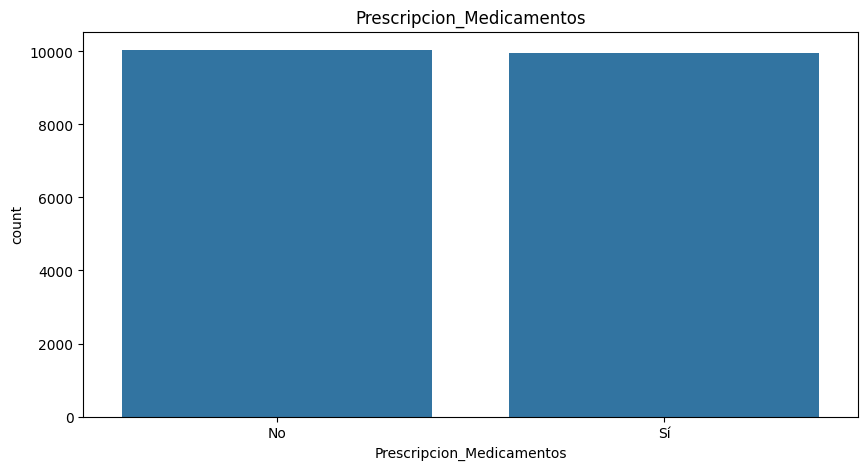

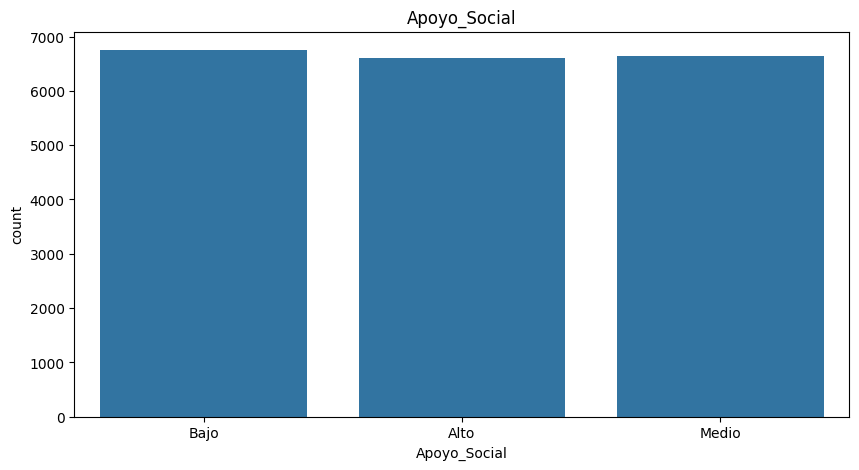

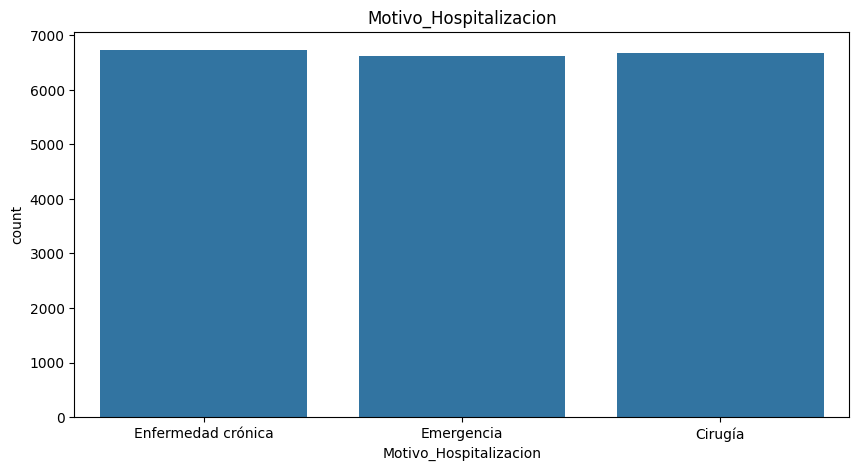

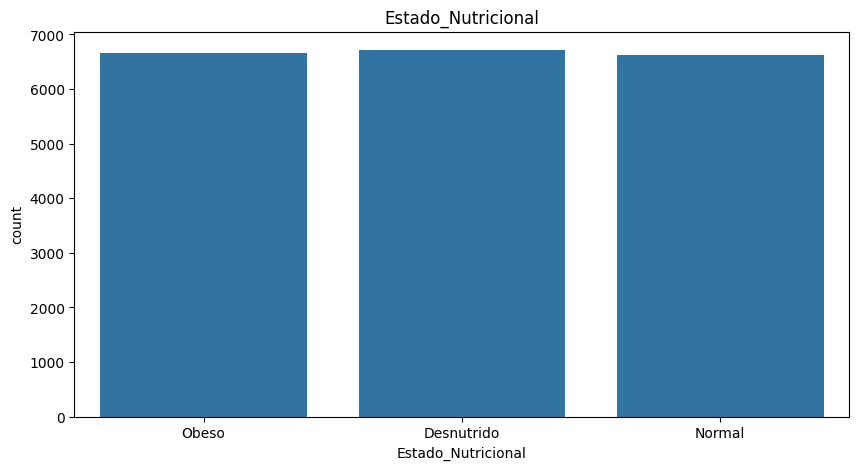

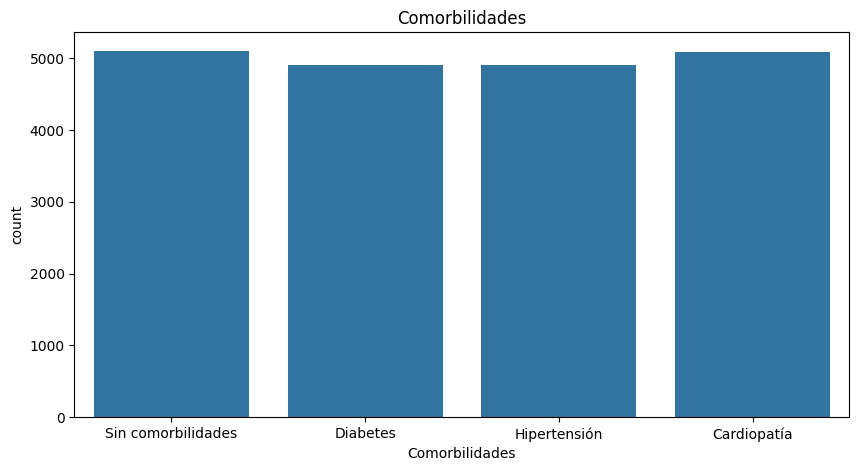

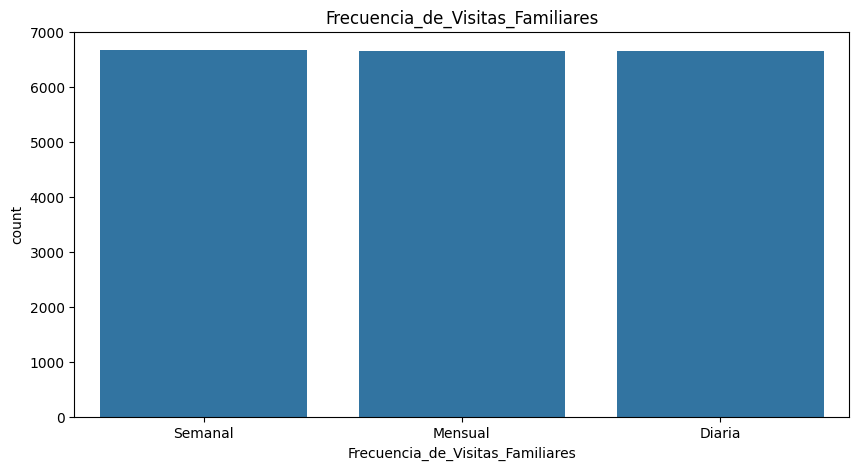

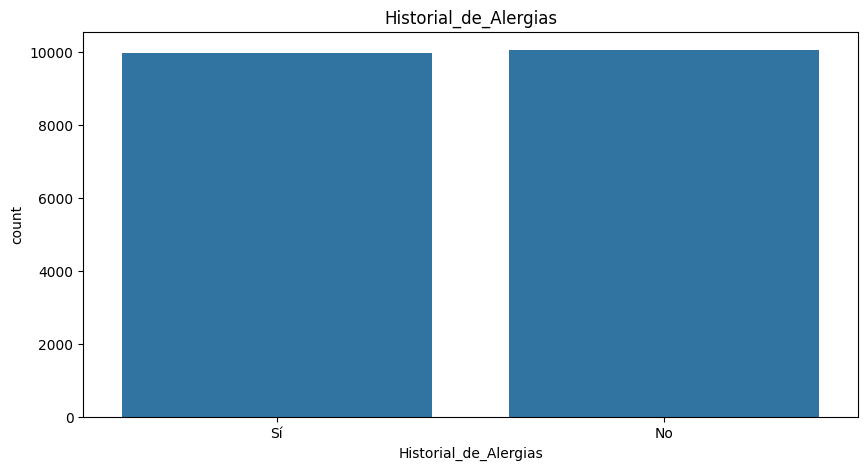

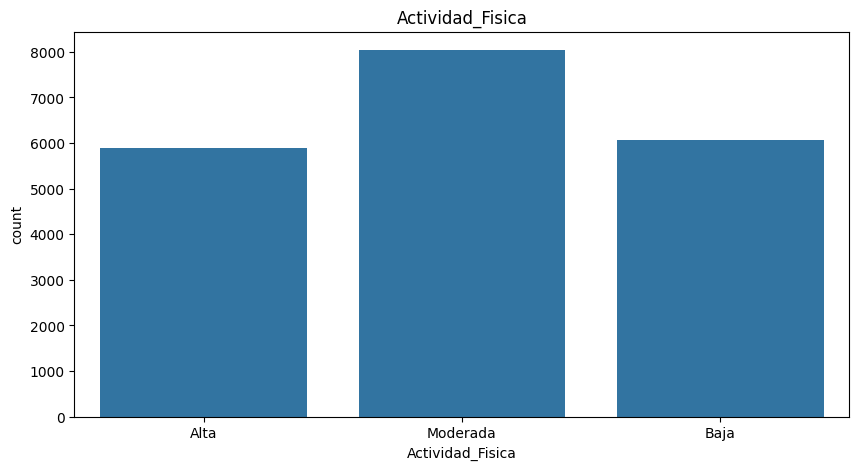

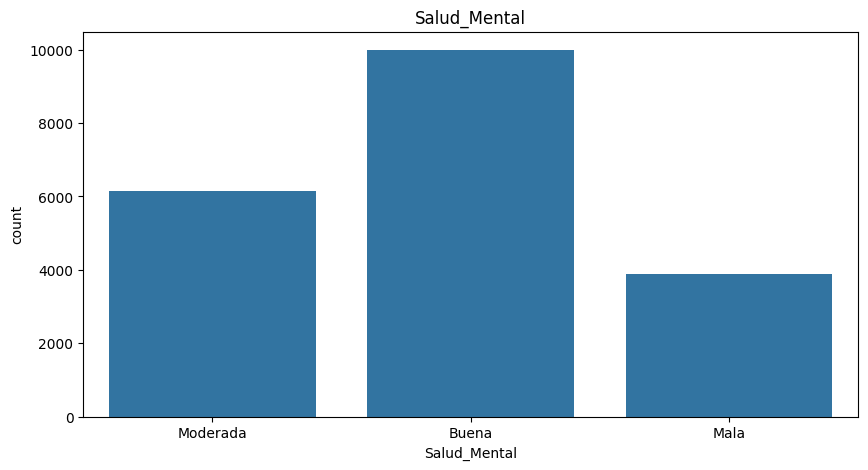

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo CSV
# from google.colab import files
# uploaded = files.upload()

# Leer el archivo CSV en un DataFrame
file_name = 'Base_de_datos_reingreso2.csv'
data = pd.read_csv(file_name)

# Mostrar las primeras filas del DataFrame
print("Primeras filas del DataFrame:")
print(data.head())

# Información general del DataFrame
print("\nInformación del DataFrame:")
print(data.info())

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:")
print(data.describe())

# Verificar valores nulos
print("\nValores nulos por columna:")
print(data.isnull().sum())

# Distribución de las variables numéricas
data.hist(bins=30, figsize=(20, 15))
plt.show()

# Gráfico de correlación
# Select only numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=np.number)
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.show()

# Gráficos de barras para las variables categóricas (si las hay)
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=data, x=col)  # Changed to use 'data=' and 'x='
    plt.title(col)
    plt.show()


In [8]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import seaborn as sns

# Ya subiste el archivo, ahora lo cargas en un DataFrame
archivo = '/content/Base_de_datos_reingreso2.csv'  # Ruta en Colab
df = pd.read_csv(archivo)

# Eliminar la columna 'Distancia_Al_Hospital'
df = df.drop(columns='Distancia_Al_Hospital')

# Identificar la variable objetivo y las características
X = df.drop(columns='Reingreso')
y = df['Reingreso']

# Separar las características en numéricas y categóricas
columnas_numericas = X.select_dtypes(include=[np.number]).columns.tolist()
columnas_categoricas = X.select_dtypes(include=[object]).columns.tolist()

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el preprocesador y el modelo
preprocesador = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
        ('cat', OneHotEncoder(), columnas_categoricas)
    ]
)

# Pipeline para regresión logística
pipeline_logistic = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('modelo', LogisticRegression(max_iter=1000, random_state=42))
])
pipeline_logistic.fit(X_train, y_train)

# Pipeline para RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
pipeline_rf = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('modelo', rf_model)
])
pipeline_rf.fit(X_train, y_train)

# Pipeline para Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
pipeline_gb = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('modelo', gb_model)
])
pipeline_gb.fit(X_train, y_train)


# --- Code from the cell that had the error ---

# Obtener nombres de características
preprocesador_ajustado = pipeline_logistic.named_steps['preprocesador']
onehot_encoder = preprocesador_ajustado.named_transformers_['cat']
onehot_encoder.fit(X_train[columnas_categoricas])  # Ajustar el OneHotEncoder
nombres_columnas = onehot_encoder.get_feature_names_out(columnas_categoricas)
nombres_columnas_numericas = columnas_numericas
nombres_columnas_rf = np.concatenate([nombres_columnas_numericas, nombres_columnas])

# Obtener coeficientes de regresión logística
coeficientes = pipeline_logistic.named_steps['modelo'].coef_[0]
df_coeficientes = pd.DataFrame({
    'Característica': nombres_columnas_rf,
    'Coeficiente_Logistico': coeficientes
})

# Calcular los valores absolutos de los coeficientes
df_coeficientes['Abs_Coeficiente_Logistico'] = df_coeficientes['Coeficiente_Logistico'].abs()

# Obtener importancias de características de RandomForest
importancias_rf = pipeline_rf.named_steps['modelo'].feature_importances_
df_importancias_rf = pd.DataFrame({
    'Característica': nombres_columnas_rf,
    'Importancia_RF': importancias_rf
})

# Obtener importancias de características de Gradient Boosting
importancias_gb = pipeline_gb.named_steps['modelo'].feature_importances_
df_importancias_gb = pd.DataFrame({
    'Característica': nombres_columnas_rf,
    'Importancia_GB': importancias_gb
})

# Normalizar importancias y co

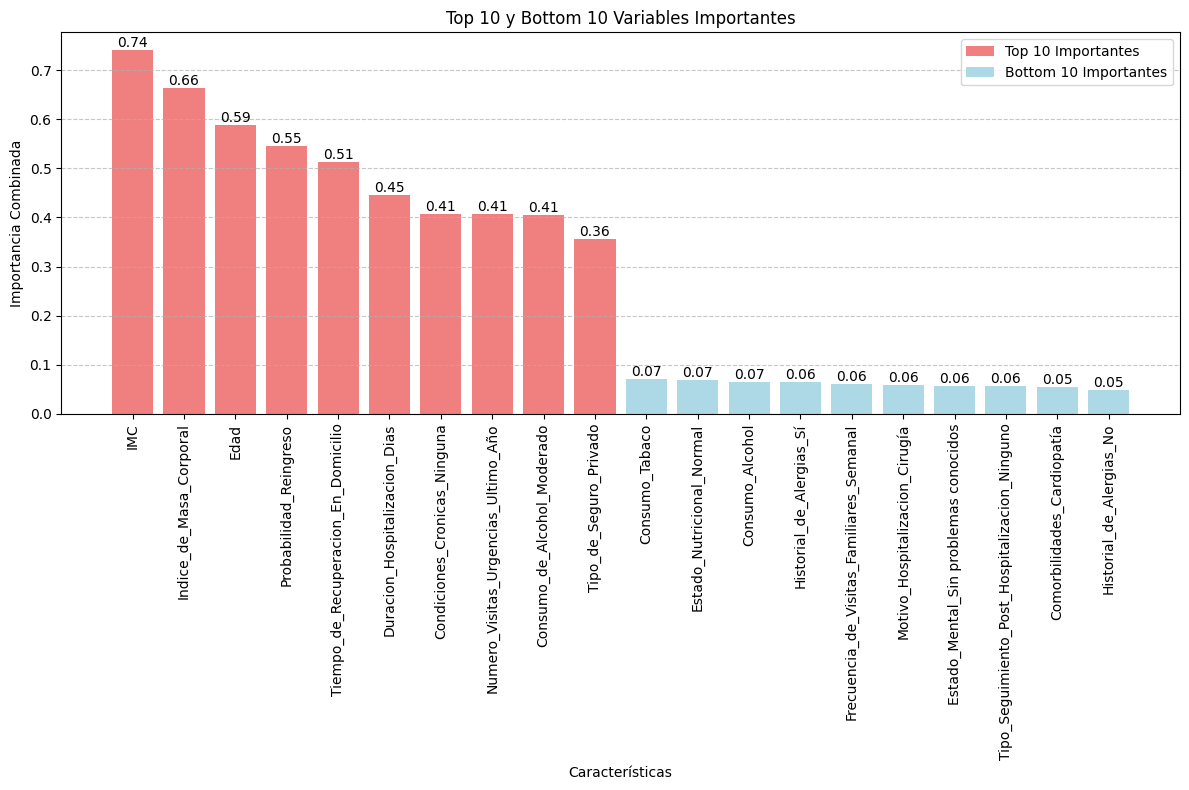

In [9]:
# Obtener nombres de características
preprocesador_ajustado = pipeline_logistic.named_steps['preprocesador']
onehot_encoder = preprocesador_ajustado.named_transformers_['cat']
onehot_encoder.fit(X_train[columnas_categoricas])  # Ajustar el OneHotEncoder
nombres_columnas = onehot_encoder.get_feature_names_out(columnas_categoricas)

nombres_columnas_numericas = columnas_numericas
nombres_columnas_rf = np.concatenate([nombres_columnas_numericas, nombres_columnas])

# Obtener coeficientes de regresión logística
coeficientes = pipeline_logistic.named_steps['modelo'].coef_[0]
df_coeficientes = pd.DataFrame({
    'Característica': nombres_columnas_rf,
    'Coeficiente_Logistico': coeficientes
})

# Calcular los valores absolutos de los coeficientes
df_coeficientes['Abs_Coeficiente_Logistico'] = df_coeficientes['Coeficiente_Logistico'].abs()

# Obtener importancias de características de RandomForest
importancias_rf = pipeline_rf.named_steps['modelo'].feature_importances_
df_importancias_rf = pd.DataFrame({
    'Característica': nombres_columnas_rf,
    'Importancia_RF': importancias_rf
})

# Obtener importancias de características de Gradient Boosting
importancias_gb = pipeline_gb.named_steps['modelo'].feature_importances_
df_importancias_gb = pd.DataFrame({
    'Característica': nombres_columnas_rf,
    'Importancia_GB': importancias_gb
})

# Normalizar importancias y coeficientes
df_coeficientes['Coeficiente_Logistico_Normalizado'] = df_coeficientes['Abs_Coeficiente_Logistico'] / df_coeficientes['Abs_Coeficiente_Logistico'].max()
df_importancias_rf['Importancia_RF_Normalizada'] = df_importancias_rf['Importancia_RF'] / df_importancias_rf['Importancia_RF'].max()
df_importancias_gb['Importancia_GB_Normalizada'] = df_importancias_gb['Importancia_GB'] / df_importancias_gb['Importancia_GB'].max()

# Combinar las importancias
df_combined = pd.merge(df_coeficientes[['Característica', 'Coeficiente_Logistico_Normalizado']],
                       df_importancias_rf[['Característica', 'Importancia_RF_Normalizada']],
                       on='Característica', how='left')

df_combined = pd.merge(df_combined,
                       df_importancias_gb[['Característica', 'Importancia_GB_Normalizada']],
                       on='Característica', how='left')

df_combined['Importancia_Combinada'] = (df_combined['Coeficiente_Logistico_Normalizado'] +
                                        df_combined['Importancia_RF_Normalizada'].fillna(0) +
                                        df_combined['Importancia_GB_Normalizada'].fillna(0)) / 3

df_combined = df_combined.sort_values(by='Importancia_Combinada', ascending=False)

# Obtener las 10 variables más importantes y 10 menos importantes
df_top_10 = df_combined.head(10)
df_bottom_10 = df_combined.tail(10)

# Crear la gráfica con las 10 variables más importantes y 10 menos importantes
plt.figure(figsize=(12, 8))

# Gráfica para las 10 variables más importantes
plt.bar(df_top_10['Característica'], df_top_10['Importancia_Combinada'], color='lightcoral', label='Top 10 Importantes')

# Gráfica para las 10 variables menos importantes
plt.bar(df_bottom_10['Característica'], df_bottom_10['Importancia_Combinada'], color='lightblue', label='Bottom 10 Importantes')

plt.xlabel('Características')
plt.ylabel('Importancia Combinada')
plt.title('Top 10 y Bottom 10 Variables Importantes')
plt.xticks(rotation=90)  # Rotar etiquetas del eje x para mayor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir anotaciones con los valores encima de las barras
for index, value in enumerate(df_top_10['Importancia_Combinada']):
    plt.text(index, value, f'{value:.2f}', va='bottom', ha='center', fontsize=10, color='black')

for index, value in enumerate(df_bottom_10['Importancia_Combinada']):
    plt.text(index + 10, value, f'{value:.2f}', va='bottom', ha='center', fontsize=10, color='black')

plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Cargar los datos
file_path = '/content/Base_de_datos_reingreso2.csv'
df = pd.read_csv(file_path)

# 2. Eliminar columnas irrelevantes y seleccionar las variables más importantes
df = df.drop(columns='Distancia_Al_Hospital')

# Variables más importantes (identificadas previamente)
top_features_adjusted = ['IMC', 'Edad', 'Probabilidad_Reingreso',
                         'Tiempo_de_Recuperacion_En_Domicilio', 'Duracion_Hospitalizacion_Dias',
                         'Numero_Visitas_Urgencias_Ultimo_Año', 'Condiciones_Cronicas', 'Consumo_de_Alcohol',
                         'Tipo_de_Seguro']

X = df[top_features_adjusted]
y = df['Reingreso']

# 3. Preprocesamiento: codificación de variables categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# 4. Entrenamiento de modelos avanzados y búsqueda de hiperparámetros rápida

# Definir los parámetros para Random Forest
parametros_rf_rapido = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Definir los parámetros para Gradient Boosting
parametros_gb_rapido = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Crear el GridSearchCV reducido para los modelos
gs_rf_rapido = GridSearchCV(RandomForestClassifier(random_state=42), parametros_rf_rapido, cv=3, scoring='f1')
gs_gb_rapido = GridSearchCV(GradientBoostingClassifier(random_state=42), parametros_gb_rapido, cv=3, scoring='f1')

# Ajustar los modelos rápidamente
gs_rf_rapido.fit(X_train, y_train)
gs_gb_rapido.fit(X_train, y_train)

# Evaluar los mejores modelos
best_rf_rapido = gs_rf_rapido.best_estimator_
best_gb_rapido = gs_gb_rapido.best_estimator_

# 5. Predicción y evaluación de los modelos

# Predicciones para RandomForest
y_pred_rf_rapido = best_rf_rapido.predict(X_test)

# Predicciones para Gradient Boosting
y_pred_gb_rapido = best_gb_rapido.predict(X_test)

# Calcular métricas para Random Forest
f1_rf_rapido = f1_score(y_test, y_pred_rf_rapido)
precision_rf_rapido = precision_score(y_test, y_pred_rf_rapido)
recall_rf_rapido = recall_score(y_test, y_pred_rf_rapido)

# Calcular métricas para Gradient Boosting
f1_gb_rapido = f1_score(y_test, y_pred_gb_rapido)
precision_gb_rapido = precision_score(y_test, y_pred_gb_rapido)
recall_gb_rapido = recall_score(y_test, y_pred_gb_rapido)

# Mostrar los mejores parámetros de cada modelo
mejores_parametros_rf_rapido = gs_rf_rapido.best_params_
mejores_parametros_gb_rapido = gs_gb_rapido.best_params_

# 6. Resultados

print("Random Forest:")
print(f"F1-Score: {f1_rf_rapido}")
print(f"Precisión: {precision_rf_rapido}")
print(f"Recall: {recall_rf_rapido}")
print(f"Mejores parámetros: {mejores_parametros_rf_rapido}")

print("\nGradient Boosting:")
print(f"F1-Score: {f1_gb_rapido}")
print(f"Precisión: {precision_gb_rapido}")
print(f"Recall: {recall_gb_rapido}")
print(f"Mejores parámetros: {mejores_parametros_gb_rapido}")


Random Forest:
F1-Score: 0.5346503106579577
Precisión: 0.509875417806138
Recall: 0.5619557937039518
Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Gradient Boosting:
F1-Score: 0.5394919168591225
Precisión: 0.4992875463094899
Recall: 0.5867381111855325
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [11]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
import ipywidgets as widgets
from IPython.display import display

# 1. Cargar los datos
file_path = '/content/Base_de_datos_reingreso2.csv'
df = pd.read_csv(file_path)

# 2. Eliminar columnas irrelevantes y seleccionar las variables más importantes
df = df.drop(columns='Distancia_Al_Hospital')

# Variables más importantes (identificadas previamente)
top_features_adjusted = ['IMC', 'Edad',
                         'Tiempo_de_Recuperacion_En_Domicilio', 'Duracion_Hospitalizacion_Dias',
                         'Numero_Visitas_Urgencias_Ultimo_Año', 'Condiciones_Cronicas', 'Consumo_de_Alcohol',
                         'Consumo_de_Tabaco', 'Tipo_de_Seguro']

X = df[top_features_adjusted]
y = df['Reingreso']

# 3. Preprocesamiento: codificación de variables categóricas
X_encoded = pd.get_dummies(X, drop_first=True)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Entrenar el mejor modelo
best_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=50, random_state=42)
best_model.fit(X_train, y_train)

# 4. Crear widgets para ingresar las características de manera interactiva

# Definir las opciones para cada característica de selección múltiple
condiciones_cronicas_options = ['Ninguna', 'Una', 'Dos', 'Tres o más']
consumo_alcohol_options = ['Sí', 'No']
consumo_tabaco_options = ['Sí', 'No']
tipo_seguro_options = ['Público', 'Privado']

# Crear widgets interactivos para las características
edad_slider = widgets.IntSlider(value=40, min=18, max=90, step=1, description='Edad:')
imc_slider = widgets.FloatSlider(value=25.0, min=15.0, max=40.0, step=0.1, description='IMC:')
tiempo_rec_slider = widgets.IntSlider(value=30, min=1, max=60, step=1, description='Tiempo Recuperación:')
duracion_hosp_slider = widgets.IntSlider(value=10, min=1, max=50, step=1, description='Duración Hosp. (días):')
visitas_urg_slider = widgets.IntSlider(value=3, min=0, max=10, step=1, description='Visitas Urgencias:')
condiciones_cronicas_select = widgets.Dropdown(options=condiciones_cronicas_options, description='Cond. Crónicas:')
consumo_alcohol_select = widgets.Dropdown(options=consumo_alcohol_options, description='Consumo Alcohol:')
consumo_tabaco_select = widgets.Dropdown(options=consumo_tabaco_options, description='Consumo Tabaco:')
tipo_seguro_select = widgets.Dropdown(options=tipo_seguro_options, description='Tipo Seguro:')

# Función para predecir la probabilidad de reingreso
def predecir_probabilidad(edad, imc, tiempo_rec, duracion_hosp, visitas_urg, cond_cronicas, consumo_alcohol, consumo_tabaco, tipo_seguro):
    # Crear un nuevo dataframe con los valores ingresados
    nuevo_paciente = pd.DataFrame({
        'IMC': [imc],
        'Edad': [edad],
        'Tiempo_de_Recuperacion_En_Domicilio': [tiempo_rec],
        'Duracion_Hospitalizacion_Dias': [duracion_hosp],
        'Numero_Visitas_Urgencias_Ultimo_Año': [visitas_urg],
        'Condiciones_Cronicas_' + cond_cronicas: [1],
        'Consumo_de_Alcohol_' + consumo_alcohol: [1],
        'Consumo_de_Tabaco_' + consumo_tabaco: [1],
        'Tipo_de_Seguro_' + tipo_seguro: [1]
    })

    # Asegurarse de que las columnas coincidan con las del modelo
    nuevo_paciente_encoded = pd.get_dummies(nuevo_paciente, drop_first=True)
    columnas_faltantes = set(X_train.columns) - set(nuevo_paciente_encoded.columns)
    for col in columnas_faltantes:
        nuevo_paciente_encoded[col] = 0  # Rellenar las columnas faltantes con ceros

    # Reordenar las columnas para que coincidan
    nuevo_paciente_encoded = nuevo_paciente_encoded[X_train.columns]

    # Predecir la probabilidad de reingreso
    probabilidad = best_model.predict_proba(nuevo_paciente_encoded)[0][1]

    print(f"La probabilidad de reingreso es: {probabilidad * 100:.2f}%")

# 5. Conectar los widgets a la función interactiva
input_widgets = [edad_slider, imc_slider, tiempo_rec_slider,
                 duracion_hosp_slider, visitas_urg_slider, condiciones_cronicas_select,
                 consumo_alcohol_select, consumo_tabaco_select, tipo_seguro_select]

output = widgets.interactive_output(predecir_probabilidad, {
    'edad': edad_slider,
    'imc': imc_slider,
    'tiempo_rec': tiempo_rec_slider,
    'duracion_hosp': duracion_hosp_slider,
    'visitas_urg': visitas_urg_slider,
    'cond_cronicas': condiciones_cronicas_select,
    'consumo_alcohol': consumo_alcohol_select,
    'consumo_tabaco': consumo_tabaco_select,
    'tipo_seguro': tipo_seguro_select
})

# Mostrar los widgets y el resultado
display(*input_widgets, output)


IntSlider(value=40, description='Edad:', max=90, min=18)

FloatSlider(value=25.0, description='IMC:', max=40.0, min=15.0)

IntSlider(value=30, description='Tiempo Recuperación:', max=60, min=1)

IntSlider(value=10, description='Duración Hosp. (días):', max=50, min=1)

IntSlider(value=3, description='Visitas Urgencias:', max=10)

Dropdown(description='Cond. Crónicas:', options=('Ninguna', 'Una', 'Dos', 'Tres o más'), value='Ninguna')

Dropdown(description='Consumo Alcohol:', options=('Sí', 'No'), value='Sí')

Dropdown(description='Consumo Tabaco:', options=('Sí', 'No'), value='Sí')

Dropdown(description='Tipo Seguro:', options=('Público', 'Privado'), value='Público')

Output()